# Microsoft Original Content Insight Project
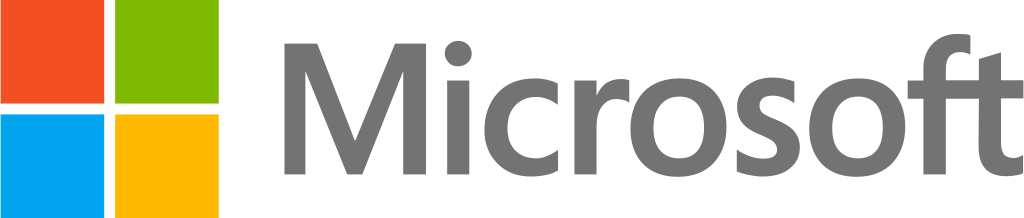

## Overview

This project analyzes the movie data from ***IMDB*** and ***The Numbers*** to help guide Micrsofts direction in the original content market.  Analysis of production budget and worldwide gross varies greatly across movie genres and Microsoft can use this data to make a more informed decision.  

## Business Problem

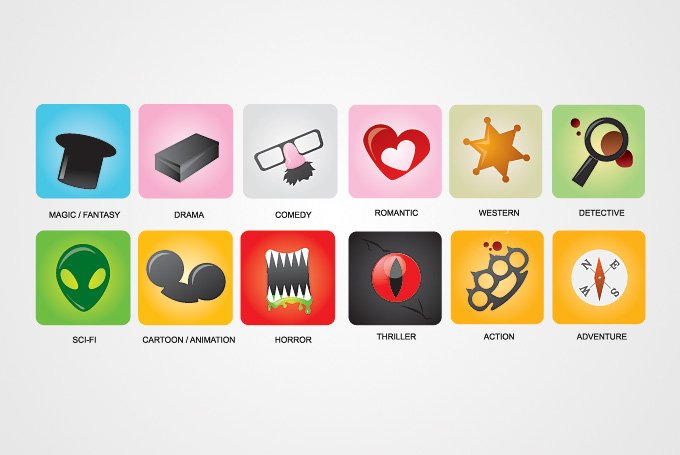

With so many genres of film, it can be hard to determine where to start.  Narrowing done these genres based on key variables will help mitigate some of the risks Microsoft faces in this new market for them.  Using production budget, worldwide gross, and genre statistics to predict the best possible genres for their first original content.

## Data Understanding

***IMDB*** provides us with an extensive database of movie information.  Here you can find everything from actors and director to release dates and runtime.  For this analysis we will focus on movie title, release year, and genres.  We will also use information from ***The Number***.  Here we once again from the movie title and release date, but we also find the production budget and gross infromation.

In [1]:
import sqlite3
from zipfile import ZipFile
import pandas as pd
import os
import csv
import datetime
import locale
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

## Reading the Data

*

*

*

*

*

### IMDB

In [2]:
with ZipFile('Data/im.db.zip', 'r') as zip:
    zip.extractall()

In [3]:
sqliteConnection = sqlite3.connect('im.db')

In [4]:
sql_query = """SELECT name FROM sqlite_master  
  WHERE type='table';"""

In [5]:
cursor = sqliteConnection.cursor()

In [6]:
cursor.execute(sql_query)

In [7]:
print(cursor.fetchall())

[('movie_basics',), ('directors',), ('known_for',), ('movie_akas',), ('movie_ratings',), ('persons',), ('principals',), ('writers',)]


From these tabels, I want to take a look at `movie_basics` and `movie_akas` to see if they have information that is useful to my analysis.

#### IMDB Movie Basics

In [8]:
imdb_basics = pd.read_sql("""
SELECT *
  FROM movie_basics;
""", sqliteConnection)

imdb_basics.head()

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"


In [9]:
imdb_basics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146144 entries, 0 to 146143
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   movie_id         146144 non-null  object 
 1   primary_title    146144 non-null  object 
 2   original_title   146123 non-null  object 
 3   start_year       146144 non-null  int64  
 4   runtime_minutes  114405 non-null  float64
 5   genres           140736 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 6.7+ MB


#### IMDB Movie AKAs

In [10]:
imdb_akas = pd.read_sql("""
SELECT *
  FROM movie_akas;
""", sqliteConnection)

imdb_akas.head()

,movie_id,ordering,title,region,language,types,attributes,is_original_title
0,tt0369610,10,Джурасик свят,BG,bg,None,None,0.0
1,tt0369610,11,Jurashikku warudo,JP,None,imdbDisplay,None,0.0
2,tt0369610,12,Jurassic World: O Mundo dos Dinossauros,BR,None,imdbDisplay,None,0.0
3,tt0369610,13,O Mundo dos Dinossauros,BR,None,None,short title,0.0
4,tt0369610,14,Jurassic World,FR,None,imdbDisplay,None,0.0


In [11]:
os.remove('im.db')

### Bom Movie Gross

In [12]:
# Connect to Bom Movie Gross csv file
bom_movie_gross = pd.read_csv('data/bom.movie_gross.csv')

In [13]:
# Visualize is data to get an idea of what is contains
bom_movie_gross.head()

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010


In [14]:
bom_movie_gross.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3387 non-null   object 
 1   studio          3382 non-null   object 
 2   domestic_gross  3359 non-null   float64
 3   foreign_gross   2037 non-null   object 
 4   year            3387 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 132.4+ KB


### The Numbers

In [15]:
# Connect to Bom Movie Gross csv file
tn_movie_budget = pd.read_csv('data/tn.movie_budgets.csv')

In [16]:
# Visualize is data to get an idea of what is contains
tn_movie_budget.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In [17]:
tn_movie_budget.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


Since it looks like there is no missing data, let's see if there is duplicate information.

In [18]:
tn_movie_budget.duplicated().values.any()

False

There is also no duplicate data.  This looks like the best options for our budget information.

## Cleaning the Data
*

*

*

*

*

*

*

### IMDB Movie Basics
This dataframe has for both merging the dataframes (`release year` and `movie`) as well as important information for the analysis (`production_budget`, `domestic_gross`, and `worldwide_gross`).  Let start by seeing what kind of information it contains using `.info`.

In [19]:
# Let me see what kind of data we have.
imdb_basics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146144 entries, 0 to 146143
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   movie_id         146144 non-null  object 
 1   primary_title    146144 non-null  object 
 2   original_title   146123 non-null  object 
 3   start_year       146144 non-null  int64  
 4   runtime_minutes  114405 non-null  float64
 5   genres           140736 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 6.7+ MB


We can see that we have some missing values.

In [20]:
# This will tell me how many null values we have and where they are.
imdb_basics.isnull().sum()

movie_id               0
primary_title          0
original_title        21
start_year             0
runtime_minutes    31739
genres              5408
dtype: int64

Let's remove `original_title` since it is redundant.

In [21]:
# Removes the original_title column
imdb_basics = imdb_basics.drop('original_title', 1)

In [22]:
# This allows me to visually confirm the column was removed
imdb_basics.head()

,movie_id,primary_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,2017,80.0,"Comedy,Drama,Fantasy"


Next, let's review `runtime_minutes`.  What percentage of data are we dealing with.

In [23]:
# I wrote a function to give me the missing percentage for
# a given column in a dataframe.
def miss_perc(column):
    perc = (column.isnull().sum() / len(column))*100
    print('There is {}% missing data'.format(round(perc, 2)))

In [24]:
# Run the function to see percentage of missing data from genres.
miss_perc(imdb_basics['genres'])

There is 3.7% missing data


3.7% is a relative small amount.  Lets remove those rows.

In [25]:
imdb_basics = imdb_basics.dropna(subset=['genres'])

In [26]:
# Let's see if it worked
imdb_basics.isnull().sum()

movie_id               0
primary_title          0
start_year             0
runtime_minutes    28503
genres                 0
dtype: int64

Now let's move onto `runtime_minutes`.

In [27]:
# Run the function to see percentage of missing data from genres.
miss_perc(imdb_basics['runtime_minutes'])

There is 20.25% missing data


20.25% is too large to just delete. Let review the `mean` and `median` data to see which would be best to replace the null values.

In [28]:
# Check the mean value for runtime.
imdb_basics['runtime_minutes'].mean()

86.26190157974928

In [29]:
# Check the mean value for runtime.
imdb_basics['runtime_minutes'].median()

87.0

Since they are both so close, we could use either.  Let's go with `median` to keep the data cleaner.

In [30]:
# Replace all missing data in runtime with median value.
imdb_basics.fillna(value=87, inplace=True)

In [31]:
# Let's see if it worked
imdb_basics.isnull().sum()

movie_id           0
primary_title      0
start_year         0
runtime_minutes    0
genres             0
dtype: int64

Let's see if we have any duplicate data.

In [32]:
imdb_basics.duplicated().values.any()

False

Now that we know that there is no duplicate data, we can move on.

Next, let's rename `primary_title` to `movie` to be more consistant across all the dataframes. We'll also change the index to `movie` for easier merging later.

In [33]:
# Changes the column name from 'primary_title' to 'movie'.
imdb_basics.rename(columns={'primary_title':'movie'}, inplace=True)

# Changes the index from 'movie_id' to 'movie'.
imdb_basics.set_index('movie', inplace=True)

imdb_basics.info()

<class 'pandas.core.frame.DataFrame'>
Index: 140736 entries, Sunghursh to Chico Albuquerque - Revelações
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   movie_id         140736 non-null  object 
 1   start_year       140736 non-null  int64  
 2   runtime_minutes  140736 non-null  float64
 3   genres           140736 non-null  object 
dtypes: float64(1), int64(1), object(2)
memory usage: 5.4+ MB


Now that we no longer need it, let's remove column `movie_id`.

In [34]:
# Removes column 'movie_id'.
imdb_basics = imdb_basics.drop('movie_id', 1)

# Let's view the dataframe to make sure we have it the way we want.
imdb_basics.head()

,start_year,runtime_minutes,genres
movie,,,
Sunghursh,2013,175.0,"Action,Crime,Drama"
One Day Before the Rainy Season,2019,114.0,"Biography,Drama"
The Other Side of the Wind,2018,122.0,Drama
Sabse Bada Sukh,2018,87.0,"Comedy,Drama"
The Wandering Soap Opera,2017,80.0,"Comedy,Drama,Fantasy"


### The Numbers budget data

In [35]:
# Let's see what kind of data we have.
tn_movie_budget.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


In [36]:
# View how much data we have missing.
tn_movie_budget.isnull().sum()

id                   0
release_date         0
movie                0
production_budget    0
domestic_gross       0
worldwide_gross      0
dtype: int64

No missing data.  Let's see if we have any duplicates.

In [37]:
tn_movie_budget.duplicated().values.any()

False

In [38]:
# Visualize the data
tn_movie_budget.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


We know that `production_budget`, `domestic_gross`, and `worldwide_gross` are `strings` and we need them to be `integers`. Let's start by removing the '$' and ','.

In [39]:
# Removes the $ and, from all three columns.
tn_movie_budget['production_budget'] = tn_movie_budget['production_budget'].replace('[$,]','', regex=True)
tn_movie_budget['domestic_gross'] = tn_movie_budget['domestic_gross'].replace('[$,]','', regex=True)
tn_movie_budget['worldwide_gross']=tn_movie_budget['worldwide_gross'].replace('[$,]','', regex=True)

# Visually check to see if it worked.
tn_movie_budget.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,425000000,760507625,2776345279
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875
2,3,"Jun 7, 2019",Dark Phoenix,350000000,42762350,149762350
3,4,"May 1, 2015",Avengers: Age of Ultron,330600000,459005868,1403013963
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747


Stripping the the string worked, but they are still strings as you can see below.

In [40]:
tn_movie_budget.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


Use `pd.to_numeric` to convert each of these columns to intergers.

In [41]:
# Converts production budget from string to integer
tn_movie_budget['production_budget'] = pd.to_numeric(tn_movie_budget['production_budget'])

In [42]:
# Converts domestic gross from string to integer
tn_movie_budget['domestic_gross'] = pd.to_numeric(tn_movie_budget['domestic_gross'])

In [43]:
# Converts worldwide gross from string to integer
tn_movie_budget['worldwide_gross'] = pd.to_numeric(tn_movie_budget['worldwide_gross'])

Let's make sure it worked.

In [44]:
# Let's me see that the strings were changed to integers.
tn_movie_budget.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   int64 
 4   domestic_gross     5782 non-null   int64 
 5   worldwide_gross    5782 non-null   int64 
dtypes: int64(4), object(2)
memory usage: 271.2+ KB


The `imdb_basics` dataframe uses `start_year`.  Let me pull the year out of the `release_date` and make it it's own column.  This will help when we merge later.

In [45]:
# Converts release_date to datetime and creates a new column with just the year.
tn_movie_budget['year'] = pd.DatetimeIndex(tn_movie_budget['release_date']).year

# Visually check to see if it worked.
tn_movie_budget.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,year
0,1,"Dec 18, 2009",Avatar,425000000,760507625,2776345279,2009
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,2011
2,3,"Jun 7, 2019",Dark Phoenix,350000000,42762350,149762350,2019
3,4,"May 1, 2015",Avengers: Age of Ultron,330600000,459005868,1403013963,2015
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747,2017


Let's set the `index` to `movie` just like we did with the IMDB database.

In [46]:
# Changes the index from 'movie_id' to 'movie'.
tn_movie_budget.set_index('movie', inplace=True)

tn_movie_budget.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5782 entries, Avatar to My Date With Drew
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   production_budget  5782 non-null   int64 
 3   domestic_gross     5782 non-null   int64 
 4   worldwide_gross    5782 non-null   int64 
 5   year               5782 non-null   int64 
dtypes: int64(5), object(1)
memory usage: 316.2+ KB


Now that we no longer need the `id` column, let's remove it.

In [47]:
# Removes the id column
tn_movie_budget = tn_movie_budget.drop('id', 1)

# Let's view the dataframe to make sure we have it the way we want.
tn_movie_budget.head()

,release_date,production_budget,domestic_gross,worldwide_gross,year
movie,,,,,
Avatar,"Dec 18, 2009",425000000,760507625,2776345279,2009
Pirates of the Caribbean: On Stranger Tides,"May 20, 2011",410600000,241063875,1045663875,2011
Dark Phoenix,"Jun 7, 2019",350000000,42762350,149762350,2019
Avengers: Age of Ultron,"May 1, 2015",330600000,459005868,1403013963,2015
Star Wars Ep. VIII: The Last Jedi,"Dec 15, 2017",317000000,620181382,1316721747,2017


Let convert `release_date` from a string to datetime using `pd.to_datetime()`.  This will name it easier to analyze the data laters.

In [48]:
# Converts date from string to datetime.
tn_movie_budget['release_date'] = pd.to_datetime(tn_movie_budget['release_date'])

# Let's see if it works.
tn_movie_budget.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5782 entries, Avatar to My Date With Drew
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   release_date       5782 non-null   datetime64[ns]
 1   production_budget  5782 non-null   int64         
 2   domestic_gross     5782 non-null   int64         
 3   worldwide_gross    5782 non-null   int64         
 4   year               5782 non-null   int64         
dtypes: datetime64[ns](1), int64(4)
memory usage: 271.0+ KB


Now that we have both dataframes like we want them, merge them using `.merge()`.  We will use `movie` and `year` to merge the data.  This will insure that we don't merge movies with the same titles.

In [49]:
# Combines the IMDB table with The Numbers budget information
# along movie and year.
movies_df = pd.merge(imdb_basics, tn_movie_budget, left_on=['movie', 'start_year'], right_on=['movie', 'year'])
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1541 entries, Foodfight! to Unplanned
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   start_year         1541 non-null   int64         
 1   runtime_minutes    1541 non-null   float64       
 2   genres             1541 non-null   object        
 3   release_date       1541 non-null   datetime64[ns]
 4   production_budget  1541 non-null   int64         
 5   domestic_gross     1541 non-null   int64         
 6   worldwide_gross    1541 non-null   int64         
 7   year               1541 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(5), object(1)
memory usage: 108.4+ KB


Everything looks good.

In [50]:
# Visualize the data
movies_df.head(25)

,start_year,runtime_minutes,genres,release_date,production_budget,domestic_gross,worldwide_gross,year
movie,,,,,,,,
Foodfight!,2012,91.0,"Action,Animation,Comedy",2012-12-31,45000000,0,73706,2012
The Secret Life of Walter Mitty,2013,114.0,"Adventure,Comedy,Drama",2013-12-25,91000000,58236838,187861183,2013
A Walk Among the Tombstones,2014,114.0,"Action,Crime,Drama",2014-09-19,28000000,26017685,62108587,2014
Jurassic World,2015,124.0,"Action,Adventure,Sci-Fi",2015-06-12,215000000,652270625,1648854864,2015
The Rum Diary,2011,119.0,"Comedy,Drama",2011-10-28,45000000,13109815,21544732,2011
The Three Stooges,2012,92.0,"Comedy,Family",2012-04-13,30000000,44338224,54052249,2012
Anderson's Cross,2010,98.0,"Comedy,Drama,Romance",2010-12-31,300000,0,0,2010
Tangled,2010,100.0,"Adventure,Animation,Comedy",2010-11-24,260000000,200821936,586477240,2010
John Carter,2012,132.0,"Action,Adventure,Sci-Fi",2012-03-09,275000000,73058679,282778100,2012


## Analysis
*

1. Genre
2. Runtime
3. Release date

*

*

*

*

*

*

Let's start by finding the top 100 movies.  We can use `.sort_values()` along `worldwide_gross` and set that as a new dataframe.

In [51]:
# Sorts values in decending order and limits it to the first 100.
top_100_movies = movies_df.sort_values(['worldwide_gross'], ascending=False)[0:100]

top_100_movies

,start_year,runtime_minutes,genres,release_date,production_budget,domestic_gross,worldwide_gross,year
movie,,,,,,,,
Avengers: Infinity War,2018,149.0,"Action,Adventure,Sci-Fi",2018-04-27,300000000,678815482,2048134200,2018
Jurassic World,2015,124.0,"Action,Adventure,Sci-Fi",2015-06-12,215000000,652270625,1648854864,2015
Furious 7,2015,137.0,"Action,Crime,Thriller",2015-04-03,190000000,353007020,1518722794,2015
The Avengers,2012,143.0,"Action,Adventure,Sci-Fi",2012-05-04,225000000,623279547,1517935897,2012
Avengers: Age of Ultron,2015,141.0,"Action,Adventure,Sci-Fi",2015-05-01,330600000,459005868,1403013963,2015
...,...,...,...,...,...,...,...,...
Kong: Skull Island,2017,118.0,"Action,Adventure,Fantasy",2017-03-10,185000000,168052812,561072059,2017
Cars 2,2011,106.0,"Adventure,Animation,Comedy",2011-06-24,200000000,191450875,560155383,2011
Ted,2012,106.0,"Comedy,Fantasy",2012-06-29,50000000,218665740,556016627,2012


We can delete the two redundant year columns.

In [52]:
# Removes 'start_year' 
top_100_movies = top_100_movies.drop('start_year', 1)

# Removes year
top_100_movies = top_100_movies.drop('year', 1)

Let's see if it worked.

In [53]:
top_100_movies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100 entries, Avengers: Infinity War to Brave
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   runtime_minutes    100 non-null    float64       
 1   genres             100 non-null    object        
 2   release_date       100 non-null    datetime64[ns]
 3   production_budget  100 non-null    int64         
 4   domestic_gross     100 non-null    int64         
 5   worldwide_gross    100 non-null    int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 5.5+ KB


### 1) Genre
Let's start by breaking down the `genres` and then we can compare the to our `budget` and `gross` data.

First we need to split the string of data in `genres` into a list. We can do this by using the `lambda` function to `.apply()` a `.split()` at the commas.

In [54]:
# Split the genre data at the commas.
top_100_movies['genres'] = top_100_movies['genres'].apply(lambda x: x.split(",") if x else x)

# Let's see if it worked
top_100_movies

,runtime_minutes,genres,release_date,production_budget,domestic_gross,worldwide_gross
movie,,,,,,
Avengers: Infinity War,149.0,"[Action, Adventure, Sci-Fi]",2018-04-27,300000000,678815482,2048134200
Jurassic World,124.0,"[Action, Adventure, Sci-Fi]",2015-06-12,215000000,652270625,1648854864
Furious 7,137.0,"[Action, Crime, Thriller]",2015-04-03,190000000,353007020,1518722794
The Avengers,143.0,"[Action, Adventure, Sci-Fi]",2012-05-04,225000000,623279547,1517935897
Avengers: Age of Ultron,141.0,"[Action, Adventure, Sci-Fi]",2015-05-01,330600000,459005868,1403013963
...,...,...,...,...,...,...
Kong: Skull Island,118.0,"[Action, Adventure, Fantasy]",2017-03-10,185000000,168052812,561072059
Cars 2,106.0,"[Adventure, Animation, Comedy]",2011-06-24,200000000,191450875,560155383
Ted,106.0,"[Comedy, Fantasy]",2012-06-29,50000000,218665740,556016627


Now that we have the `genres` seperated out into a list, let's make a set of all the unique genres.

In [70]:
# Iterate through the rows of data and put each
# unique genre into a new set.

all_genres = set()

for genre in top_100_movies['genres']:
    for x in genre:
        if x not in all_genres:
            all_genres.add(x)
            
# Let's see if it worked
all_genres

{'Action',
 'Adventure',
 'Animation',
 'Biography',
 'Comedy',
 'Crime',
 'Drama',
 'Family',
 'Fantasy',
 'Horror',
 'Music',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Thriller'}

Now that we have each individual `genre`, let's see how many we have.

In [71]:
# Shows the length of all_genres
len(all_genres)

16

Lets add a column for each movie genre.  This will make it easier to analyze the data based on genre. 

In [74]:
# This iterates through all_genres and creates a column
# named after that genre.
for genre in all_genres:
    # Set the values to 0
    top_100_movies[genre] = 0
    
# Let's see if it works
top_100_movies

,runtime_minutes,genres,release_date,production_budget,domestic_gross,worldwide_gross,Family,Thriller,Fantasy,Animation,...,Crime,Comedy,Mystery,Music,Drama,Horror,Musical,Adventure,Sci-Fi,Action
movie,,,,,,,,,,,,,,,,,,,,,
Avengers: Infinity War,149.0,"[Action, Adventure, Sci-Fi]",2018-04-27,300000000,678815482,2048134200,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Jurassic World,124.0,"[Action, Adventure, Sci-Fi]",2015-06-12,215000000,652270625,1648854864,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Furious 7,137.0,"[Action, Crime, Thriller]",2015-04-03,190000000,353007020,1518722794,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
The Avengers,143.0,"[Action, Adventure, Sci-Fi]",2012-05-04,225000000,623279547,1517935897,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Avengers: Age of Ultron,141.0,"[Action, Adventure, Sci-Fi]",2015-05-01,330600000,459005868,1403013963,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Kong: Skull Island,118.0,"[Action, Adventure, Fantasy]",2017-03-10,185000000,168052812,561072059,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Cars 2,106.0,"[Adventure, Animation, Comedy]",2011-06-24,200000000,191450875,560155383,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Ted,106.0,"[Comedy, Fantasy]",2012-06-29,50000000,218665740,556016627,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Now we need to iterate through the table again, this time if the genre is in `genres`, we will set the value equal to 1.

In [77]:
# This iterates through each row of data. For each genre
# in that row, is will set the matching column equal to 1.
for index, row in top_100_movies.iterrows():
    if row['genres']:
        for genre in row['genres']:
            top_100_movies.loc[index, genre] = 1
            
# Let's see if it workd
top_100_movies.head(10)

,runtime_minutes,genres,release_date,production_budget,domestic_gross,worldwide_gross,Family,Thriller,Fantasy,Animation,...,Crime,Comedy,Mystery,Music,Drama,Horror,Musical,Adventure,Sci-Fi,Action
movie,,,,,,,,,,,,,,,,,,,,,
Avengers: Infinity War,149.0,"[Action, Adventure, Sci-Fi]",2018-04-27,300000000,678815482,2048134200,0,0,0,0,...,0,0,0,0,0,0,0,1,1,1
Jurassic World,124.0,"[Action, Adventure, Sci-Fi]",2015-06-12,215000000,652270625,1648854864,0,0,0,0,...,0,0,0,0,0,0,0,1,1,1
Furious 7,137.0,"[Action, Crime, Thriller]",2015-04-03,190000000,353007020,1518722794,0,1,0,0,...,1,0,0,0,0,0,0,0,0,1
The Avengers,143.0,"[Action, Adventure, Sci-Fi]",2012-05-04,225000000,623279547,1517935897,0,0,0,0,...,0,0,0,0,0,0,0,1,1,1
Avengers: Age of Ultron,141.0,"[Action, Adventure, Sci-Fi]",2015-05-01,330600000,459005868,1403013963,0,0,0,0,...,0,0,0,0,0,0,0,1,1,1
Black Panther,134.0,"[Action, Adventure, Sci-Fi]",2018-02-16,200000000,700059566,1348258224,0,0,0,0,...,0,0,0,0,0,0,0,1,1,1
Jurassic World: Fallen Kingdom,128.0,"[Action, Adventure, Sci-Fi]",2018-06-22,170000000,417719760,1305772799,0,0,0,0,...,0,0,0,0,0,0,0,1,1,1
Frozen,102.0,"[Adventure, Animation, Comedy]",2013-11-22,150000000,400738009,1272469910,0,0,0,1,...,0,1,0,0,0,0,0,1,0,0
Beauty and the Beast,129.0,"[Family, Fantasy, Musical]",2017-03-17,160000000,504014165,1259199706,1,0,1,0,...,0,0,0,0,0,0,1,0,0,0


It worked! Not we can see what genres make up the top 100 films.  Let's start by finding out how many films are in each genre.

We can iterate through the data

In [ ]:
#
for index, row

In [ ]:
imdb = sqlite3.connect('im.db')

In [ ]:
os.remove('im.db')

In [ ]:
imdb_basics = pd.read_sql("""
SELECT *
  FROM movie_basics;
""", imdb)

imdb_basics.head(5)

### Connecting and Visualizing _The Numbers_ Data

In [ ]:
budget_gross = pd.read_csv("data/tn.movie_budgets.csv")

In [ ]:
budget_gross.head(5)

## Data Preperation

### Data cleaning

I will need to merge these dataframes along movie title and release year.  I will clean the titles titles and release years to make the merge more accurate.

- Made all titles lowercase to remove any case sensitivity.
- Removed anything after a '(' to remove a year for a remake or an AKA title.
- Removed any whitespace.
- Pulled the year out of the release date.

In [ ]:
budget_gross['movie'] = budget_gross['movie'].str.lower()
imdb_basics['primary_title'] = imdb_basics['primary_title'].str.lower()

In [ ]:
budget_gross['movie'] = budget_gross['movie'].str.split('(').str[0]
imdb_basics['primary_title'] = imdb_basics['primary_title'].str.split('(').str[0]

In [ ]:
budget_gross['movie'] = budget_gross['movie'].str.strip()
imdb_basics['primary_title'] = imdb_basics['primary_title'].str.strip()

In [ ]:
budget_gross['year'] = pd.DatetimeIndex(budget_gross['release_date']).year

### Merging

Combining the two files yields a single dataset for feature engineering and analysis. I exclude any unmatched data to ensure that there is no missing budget or movie information.

In [ ]:
movie_genres_budget = pd.merge(imdb_basics, budget_gross, left_on=['primary_title', 'start_year'], right_on=['movie', 'year'])
movie_genres_budget.head(5)

### Feature Engineering

Removed punctuation in order to use budget and gross data to calculate `Return on Investment`.

In [ ]:
movie_genres_budget['worldwide_gross']=movie_genres_budget['worldwide_gross'].replace('[$,]','', regex=True).astype(float)
movie_genres_budget['production_budget'] = movie_genres_budget['production_budget'].replace('[$,]','', regex=True).astype(float)
movie_genres_budget = movie_genres_budget[movie_genres_budget['worldwide_gross'] > 0]

I calculated the `Return on Investment` by subtracting production budget from worldwide gross.  

In [ ]:
movie_genres_budget.loc[:,'Return on Investment'] = movie_genres_budget['worldwide_gross'] - movie_genres_budget['production_budget']

Here I reduced the data down to just the information I needed for the analysis.

In [ ]:
genre_budget_cleaned = movie_genres_budget[['genres', 'production_budget', 'worldwide_gross', 'Return on Investment']]
genre_budget_cleaned.head(5)

## Analysis

### Grouping genres

I grouped the genre data together to get a better understanding of how the different genres compare to each other.  I also added in `genre_count` to get a better understanding of the data.

Once you have the number of films per genres, you can start to see of some of the biggest (and smallest) earning genres are outliers.

In [ ]:
genre_grouped = genre_budget_cleaned.groupby(['genres']).mean().astype(int).sort_values(['Return on Investment'], ascending=False)
genre_grouped = genre_grouped.reset_index()

for x in genre_grouped.index:
    genre_grouped.at[x,'genre_count'] = genre_budget_cleaned['genres'].value_counts()[genre_grouped.at[x,'genres']]

genre_grouped

In [ ]:
# Save cleaned dataset as CSV
genre_grouped.to_csv('./Data/genre_grouped.csv')

### Genres with multiple movies

Now that we have the data grouped by genre, we want to reduce this information further.
Below, I removed all of the genres that had less than 3 films.  This is so we can have
a better average across all the films in the genre and not just a genre with two films
and one of them having an extrordinary `Return on Investment`.

In [ ]:
genres_over_2_film= genre_grouped[genre_grouped.genre_count > 2]
genres_over_2_film=genres_over_2_film.reset_index()
genres_over_2_film

You can see that there is a drastic drop off in both return of investment and worldwide gross aftert the first 10 genres.

In [ ]:
genres_over_2_film.plot(y=['production_budget', 'worldwide_gross', 'Return on Investment'], grid=True, figsize=(15,8));
plt.gcf().axes[0].yaxis.get_major_formatter().set_scientific(False)

# Top 10 Genres

We've gone from 220 genres down to 111.  

Let's reduce that to the top 10 highest average return on investment.

In [ ]:
top_10_genres = genres_over_2_film.head(10)
top_10_genres = top_10_genres.reset_index()
top_10_genres = top_10_genres.drop(['level_0', 'index'], 1)
top_10_genres

The average production budget.

In [ ]:
'${:,.2f}'.format(top_10_genres['production_budget'].mean())

### Plot top 10 genres

In [ ]:
x=top_10_genres['genres']
y1=top_10_genres['Return on Investment']
y2=top_10_genres['genre_count']

top_10_genres.plot(x='genres', y=['production_budget','Return on Investment','genre_count'],
                   secondary_y='genre_count', stacked=False, kind='bar', grid=True, figsize=(15,8));
plt.title("Return on Investment / Genre Count", size=20)

plt.gcf().axes[0].yaxis.get_major_formatter().set_scientific(False)

## Conclusions

After this analysis, one genre stands out above the rest: ***Action,Adventure,Sci-Fi***

- ***Has over fifty data points in the genre.*** This gives us plenty of data points to compare against.
- ***$487 millions average return on investment.*** This is genre had the highest return of investment from
all the data analyzed.
- ***Excellent budget to gross return*** While the average budget is among the highest in these top earners,
a ***380%*** return makes this genres well worth the investment.



## Next Steps

Further analyses could yield additional insights to further improve upon these metrics.
- **Directors:** What directors produce the best return on investment inside these genres.
- **Actors:** Are there particular actors that yield a higher profit for these movies.
- **Release date:** Does the movie release date have an affect on profit?

In [ ]:
imdb.close()